<a href="https://colab.research.google.com/github/satadrudas98/Design_Optimization_Using_Ising_Machine/blob/main/ceviche_challenge_for_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/satadrudas98/ceviche-challenges.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/satadrudas98/ceviche-challenges.git to /tmp/pip-req-build-4toax3fi
  Running command git clone -q https://github.com/satadrudas98/ceviche-challenges.git /tmp/pip-req-build-4toax3fi
     |████████████████████████████████| 98 kB 3.0 MB/s 
     |████████████████████████████████| 41 kB 420 kB/s 
     |████████████████████████████████| 298 kB 35.6 MB/s 
     |████████████████████████████████| 297 kB 42.1 MB/s 
     |████████████████████████████████| 297 kB 46.2 MB/s 
     |████████████████████████████████| 297 kB 7.4 MB/s 
     |████████████████████████████████| 296 kB 49.2 MB/s 
     |████████████████████████████████| 296 kB 11.7 MB/s 
     |████████████████████████████████| 280 kB 57.1 MB/s 
     |████████████████████████████████| 280 kB 55.2 MB/s 
     |████████████████████████████████| 280 kB 70.9 MB/s 
     |████████████████████████████████| 280 kB 46.0 MB/s 


In [ ]:
import numpy as np
import ceviche_challenges
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import autograd.numpy as npa

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
from ceviche_challenges import units as u


import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [ ]:
spec = ceviche_challenges.beam_splitter.prefabs.pico_splitter_spec()
params = ceviche_challenges.beam_splitter.prefabs.pico_splitter_sim_params()
model = ceviche_challenges.beam_splitter.model.BeamSplitterModel(params, spec)

# The model class provides a convenience property, `design_variable_shape` which specifies the design shape it expects.


#design = np.ones(model.design_variable_shape)
design=np.random.rand(model.design_variable_shape[0],model.design_variable_shape[1])
#design=np.ones(shape=model.design_variable_shape, dtype=np.int64)

# The model class has a `simulate()` method which takes the design variable as an input and returns scattering parameters and fields.
s_params, fields = model.simulate(design)

In [ ]:
# Angular frequency of the source in 1/s
omega= 2*np.pi*(3*10e8)/(1550*10e-9)#2*np.pi*200e12
# Spatial resolution in meters
dl=10e-9
# Number of pixels in x-direction
Nx=int(3e-6/dl)#120
# Number of pixels in y-direction
Ny=int(3e-6/dl)#120
# Number of pixels in the PMLs in each direction
Npml=40
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=7.84#12.0
# Radius of the smoothening features
blur_radius=int(150e-9/dl)
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=500.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=int(0.5e-6/dl)#12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=wg_width/2 #8

# Number of epochs in the optimization 
Nsteps=50
# Step size for the Adam optimizer
step_size=5e-3

In [ ]:
dl=model.dl
Nx= model.shape[0]
Ny= model.shape[1]
Npml=model.pml_width
epsr_min=model.cladding_permittivity
epsr_max=model.slab_permittivity
wg_width=model.ports[0].width


blur_radius=int(200e-9/dl)

In [ ]:
###### OMEGA


omega = 2*np.pi*(3*10e8)/(1550*10e-9)


In [ ]:
model.ports

[WaveguidePort(x=22, y=145, width=50, dir=<Direction.X_POS: 1>, offset=2, order=1),
 WaveguidePort(x=318, y=145, width=50, dir=<Direction.X_NEG: -1>, offset=2, order=1),
 WaveguidePort(x=318, y=75, width=50, dir=<Direction.X_NEG: -1>, offset=2, order=1),
 WaveguidePort(x=22, y=75, width=50, dir=<Direction.X_POS: 1>, offset=2, order=1)]

In [ ]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=model.ports[0].width, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    bg_rho = model.density_bg
    design_region = model.design_region
    rho=model.density_bg
    rho[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]]=0.5
    
    

    # Input probe slice
    input_slice1 = Slice(x=np.array(model.ports[0].x),  y=np.arange(int(model.ports[0].y-model.ports[0].width/2), int(model.ports[0].y+model.ports[0].width/2)))
    input_slice2 = Slice(x=np.array(model.ports[3].x),  y=np.arange(int(model.ports[3].y-model.ports[3].width/2), int(model.ports[3].y+model.ports[3].width/2)))
    output_slice1 = Slice(x=np.array(model.ports[2].x),  y=np.arange(int(model.ports[2].y-model.ports[2].width/2), int(model.ports[2].y+model.ports[2].width/2)))
    output_slice2 = Slice(x=np.array(model.ports[1].x),  y=np.arange(int(model.ports[1].y-model.ports[1].width/2), int(model.ports[1].y+model.ports[1].width/2)))

    return rho, bg_rho, design_region, input_slice1,input_slice2, output_slice1, output_slice2

def viz_sim(epsr, source, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation1 = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    _, _, Ez1 = simulation1.solve(source1)
    simulation2 = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    _, _, Ez2 = simulation2.solve(source2)
    
    fig, ax = plt.subplots(1, 5, constrained_layout=True, figsize=(15,7))


    ceviche.viz.abs(Ez1, outline=epsr, ax=ax[0], cbar=False)
    ceviche.viz.abs(Ez2, outline=epsr, ax=ax[1], cbar=False)
    ceviche.viz.real(Ez1, outline=epsr, ax=ax[2], cbar=False)
    ceviche.viz.real(Ez2, outline=epsr, ax=ax[3], cbar=False)
    ceviche.viz.abs(epsr, ax=ax[4], cmap='Greys')
  
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[1].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[3].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[4].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
    
    plt.show()
    
    return (simulation1, simulation2, ax, fig)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)

def epsr_parameterization(rho, bg_rho, design_region, radius=blur_radius, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)
    
    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    return epsr_min + (epsr_max-epsr_min) * rho

def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))

In [ ]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))
    
    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius):
    """Helper function used below for creating the conv kernel"""
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter
    
    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    
    kernel = _create_blur_kernel(radius)
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

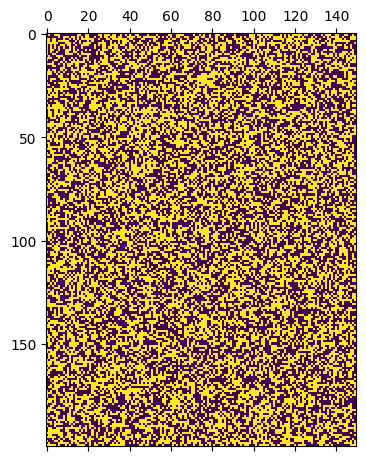

In [ ]:
plt.matshow(np.random.randint(low=0, high=2, size=model.design_variable_shape, dtype=np.int64))

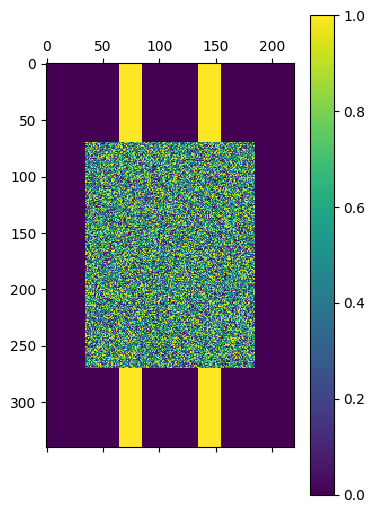

In [ ]:
plt.matshow(model.density(design))
plt.colorbar()

In [ ]:
plt.matshow(model.density_bg) #bg_rho
plt.colorbar()

In [ ]:
plt.matshow(model.epsilon_r(design))
plt.colorbar()

In [ ]:
plt.matshow(model.transform_design_variable(design))

In [ ]:
plt.matshow(model.design_region)

In [ ]:
rho=model.density_bg
rho[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]]=0.5
plt.matshow(rho)

In [ ]:
model.design_region_coords

(70, 40, 250, 200)

In [ ]:
model.shape

(600, 440)

In [ ]:
spec.pml_width

In [ ]:
model.ports[0].width

50

In [ ]:

    # Input probe slice
input_slice1 = Slice(x=np.array(model.ports[0].x),  y=np.arange(int(model.ports[0].y-model.ports[0].width/5), int(model.ports[0].y+model.ports[0].width/5)))
input_slice2 = Slice(x=np.array(model.ports[3].x),  y=np.arange(int(model.ports[3].y-model.ports[3].width/5), int(model.ports[3].y+model.ports[3].width/5)))
output_slice1 = Slice(x=np.array(model.ports[2].x),  y=np.arange(int(model.ports[2].y-model.ports[2].width/5), int(model.ports[2].y+model.ports[2].width/5)))
output_slice2 = Slice(x=np.array(model.ports[1].x),  y=np.arange(int(model.ports[1].y-model.ports[1].width/5), int(model.ports[1].y+model.ports[1].width/5)))

In [ ]:
output_slice1.x

array(636)

In [ ]:
source1 = insert_mode(omega, dl, input_slice1.x, input_slice1.y, model.epsilon_r(design), m=1)
source2 = insert_mode(omega, dl, input_slice2.x, input_slice2.y, model.epsilon_r(design), m=1)


In [ ]:
simulation, ax = viz_sim(model.epsilon_r(design), source2, slices=[input_slice, output_slice1, output_slice2])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

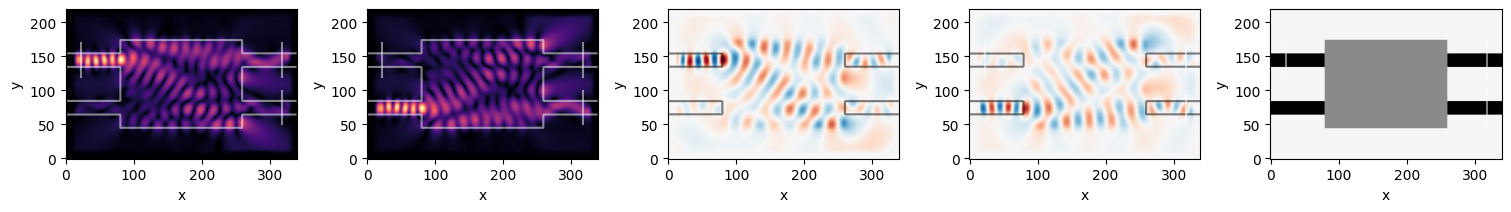

In [ ]:
rho, bg_rho, design_region, input_slice1,input_slice2, output_slice1, output_slice2 = init_domain(Nx, Ny, Npml, space=space, wg_width=model.ports[0].width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region,  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

# Setup source
source1 = insert_mode(omega, dl, input_slice1.x, input_slice1.y, epsr_init, m=1)
source2 = insert_mode(omega, dl, input_slice2.x, input_slice2.y, model.epsilon_r(design), m=1)


# Setup probe
probe1 = insert_mode(omega, dl, output_slice1.x, output_slice1.y, epsr_init, m=1)
probe2 = insert_mode(omega, dl, output_slice2.x, output_slice2.y, epsr_init, m=1)
# Simulate initial device
simulation1,simulation2,ax,fig = viz_sim(epsr_init, source1, slices=[input_slice1, output_slice1, output_slice2])

# get normalization factor (field overlap before optimizing)
_, _, Ez1 = simulation1.solve(source1)
_, _, Ez2 = simulation2.solve(source2)

E011 = mode_overlap(Ez1/np.sqrt(2), probe1)
E012 = mode_overlap(Ez1/np.sqrt(2), probe2)

E022 = mode_overlap(Ez2/np.sqrt(2), probe2)
E021 = mode_overlap(Ez2/np.sqrt(2), probe1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/100 | Duration: 4.71 secs | Value: 1.000000e+00
Epoch:   2/100 | Duration: 4.62 secs | Value: 4.313812e-01
Epoch:   3/100 | Duration: 4.62 secs | Value: 1.979323e-01
Epoch:   4/100 | Duration: 4.60 secs | Value: 5.241912e-02
Epoch:   5/100 | Duration: 4.87 secs | Value: 2.522197e-03
Epoch:   6/100 | Duration: 5.36 secs | Value: 3.509401e-02
Epoch:   7/100 | Duration: 4.65 secs | Value: 8.961787e-03
Epoch:   8/100 | Duration: 4.63 secs | Value: 1.264237e-02
Epoch:   9/100 | Duration: 4.61 secs | Value: 8.244308e-02
Epoch:  10/100 | Duration: 4.63 secs | Value: 8.204699e-02
Epoch:  11/100 | Duration: 4.60 secs | Value: 6.514069e-02
Epoch:  12/100 | Duration: 4.63 secs | Value: 1.016460e-01
Epoch:  13/100 | Duration: 4.59 secs | Value: 2.858159e-01
Epoch:  14/100 | Duration: 4.62 secs | Value: 2.489303e-01
Epoch:  15/100 | Duration: 4.58 secs | Value: 1.918342e-01
Epoch:  16/100 | Duration: 4.63 secs | Value: 2.539643e-01
Epoch:  17/100 | Duration: 4.60 secs | Value: 4.036166e-

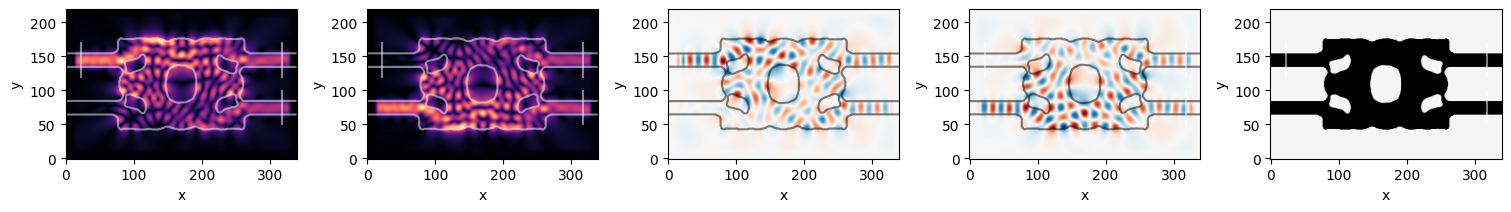

In [ ]:
def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation1.eps_r = epsr
    simulation2.eps_r = epsr
    _, _, Ez1 = simulation1.solve(source1)
    _, _, Ez2 = simulation2.solve(source2)

    return (mode_overlap(Ez1/np.sqrt(2), probe1) / E011) * (mode_overlap(Ez2/np.sqrt(2),probe2) / E022) * (mode_overlap(Ez1/np.sqrt(2),probe2) / E012) * (mode_overlap(Ez2/np.sqrt(2),probe1) / E021)

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=100, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

viz_sim(epsr, source1, slices=[input_slice1, output_slice1, output_slice2]);


In [ ]:
5.991590e+00

In [ ]:
mode_overlap(Ez1, Ez1)

8.808782206110737e-10

In [ ]:
Ez1



array([[-3.88863942e-16-2.85322582e-16j, -5.07780949e-16-5.36668848e-16j,
        -1.12970009e-15+6.39567950e-16j, ...,
         2.78231674e-14+8.51489857e-15j,  4.87416286e-15+4.62937376e-15j,
        -7.56360414e-16+1.28538630e-15j],
       [ 2.33430022e-16+1.56350445e-16j,  3.79920728e-16+5.15863496e-16j,
         3.00067010e-15+7.95221124e-16j, ...,
        -9.30048356e-15-2.51801739e-14j, -6.17487576e-16-9.17793136e-15j,
         1.22313416e-15-1.83843586e-15j],
       [ 1.61292357e-15+2.75394053e-15j,  1.13119791e-15+5.30233410e-15j,
         2.13566033e-14+1.06752189e-14j, ...,
        -6.49731061e-14-1.85264721e-13j,  8.59053334e-15-6.82933428e-14j,
         1.59752315e-14-8.76418918e-15j],
       ...,
       [-2.62015785e-14-2.64431906e-13j,  2.52568213e-14-4.59722238e-13j,
        -1.31092102e-12-8.32545085e-13j, ...,
         1.52459133e-12+5.69224545e-12j, -1.97454762e-12+2.42361071e-12j,
        -1.33951285e-12-1.55828644e-13j],
       [-2.02342962e-14-4.53237982e-14j, -2.

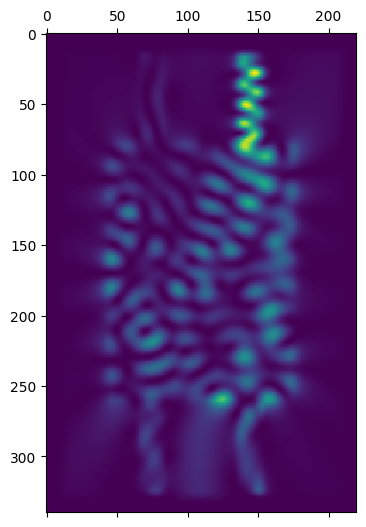

In [ ]:
plt.matshow(np.abs(Ez1*Ez1))

_____________________________________________________________________________________________________________________

________________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/  1 | Duration: 5.28 secs | Value: 1.000000e+00


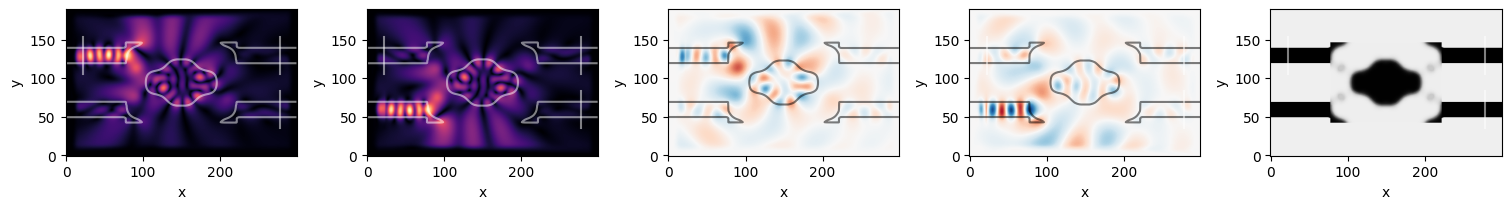

In [ ]:

def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation1.eps_r = epsr
    simulation2.eps_r = epsr
    _, _, Ez1 = simulation1.solve(source1)
    _, _, Ez2 = simulation2.solve(source2)

    return (mode_overlap(Ez1/np.sqrt(2), probe1) / E011) * (mode_overlap(Ez2/np.sqrt(2),probe2) / E022) * (mode_overlap(Ez1/np.sqrt(2),probe2) / E012) * (mode_overlap(Ez2/np.sqrt(2),probe1) / E021)

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac, Nsteps=1, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

viz_sim(epsr, source1, slices=[input_slice1, output_slice1, output_slice2]);


In [ ]:
#to record the epsilon_r distribution every iteration, this is just to generate the dataset, doesn't have to be optimized

def epsr_timestep(loss=loss, epsr=epsr):
  es=[epsr[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]].flatten()]
  l=[loss]
  #dataset=[[loss,epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten()]] #in the format [[l,a],[l,a][]]
  rho_optimum=rho
  max_obj=0


  for i in range(300):
    
    (rho_optimum, loss) = adam_optimize(objective, rho_optimum.flatten(), objective_jac, Nsteps=1, direction='max', step_size=step_size)
    if (objective(rho_optimum)>max_obj):
      max_obj=objective(rho_optimum)
      r=rho_optimum.reshape((Nx, Ny))
    rho_optimum = rho_optimum.reshape((Nx, Ny))

    epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, radius=2, N_blur=N_blur, beta=1000, eta=eta, N_proj=N_proj)
    es=np.append(es,[np.array(epsr[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]].flatten())],axis=0)
    l=np.append(l,loss)
    #dataset=np.append(dataset,[[loss,np.array(epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten())]])
  return max_obj,r,es,l

In [ ]:
max_obj,r,es,y_l=epsr_timestep()

In [ ]:
for i in es:
  i=np.reshape(i,(model.design_variable_shape[0],model.design_variable_shape[1]))
  plt.matshow(i)

In [ ]:
model.epsilon_r(np.reshape(es[290],(model.design_variable_shape[0],model.design_variable_shape[1])))

array([[ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000],
       [ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000],
       [ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000],
       ...,
       [ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000],
       [ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000],
       [ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000]])

In [ ]:
viz_sim(es[], source1, slices=[input_slice1, output_slice1, output_slice2])

Now check the s parameter and with multiple wavelengths


In [ ]:
omega = 2*np.pi*(3*10e8)/(1500*10e-9)

In [ ]:
source1 = insert_mode(omega, dl, input_slice1.x, input_slice1.y, model.epsilon_r(design), m=1)
source2 = insert_mode(omega, dl, input_slice2.x, input_slice2.y, model.epsilon_r(design), m=1)

In [ ]:
simulation1,simulation2,ax,fig = viz_sim(epsr, source1, slices=[input_slice1, output_slice1, output_slice2])

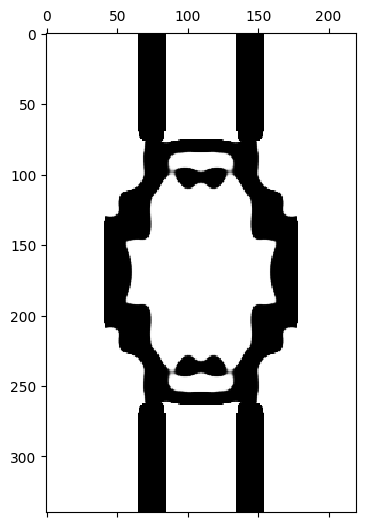

In [ ]:
plt.matshow(epsr,cmap=plt.cm.gray_r)

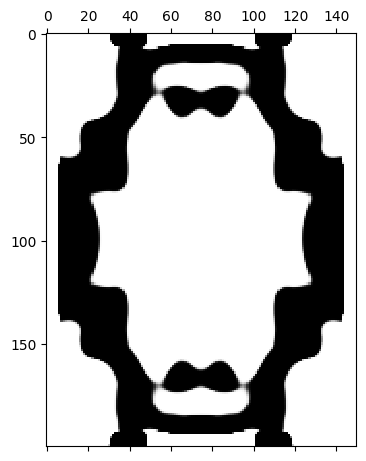

In [ ]:
plt.matshow(epsr[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]],cmap=plt.cm.gray_r)

In [ ]:
mode_overlap(Ez1, Ez1)

8.808782206110737e-10

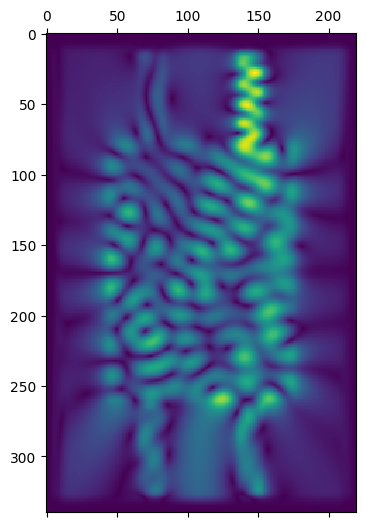

In [ ]:
plt.matshow(np.abs(Ez1))

_________________________________________

#WDM

In [ ]:
import numpy as np
import ceviche_challenges
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import autograd.numpy as npa

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
from ceviche_challenges import units as u


import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [ ]:
spec = ceviche_challenges.wdm.prefabs.wdm_spec()
params = ceviche_challenges.wdm.prefabs.wdm_sim_params()
model = ceviche_challenges.wdm.model.WdmModel(params, spec)

# The model class provides a convenience property, `design_variable_shape` which specifies the design shape it expects.


#design = np.ones(model.design_variable_shape)
design=np.random.rand(model.design_variable_shape[0],model.design_variable_shape[1])
#design=np.ones(shape=model.design_variable_shape, dtype=np.int64)

# The model class has a `simulate()` method which takes the design variable as an input and returns scattering parameters and fields.
s_params, fields = model.simulate(design)

In [ ]:
# Angular frequency of the source in 1/s
omega= 2*np.pi*(3*10e8)/(1550*10e-9)#2*np.pi*200e12
# Spatial resolution in meters
dl=10e-9
# Number of pixels in x-direction
Nx=int(3e-6/dl)#120
# Number of pixels in y-direction
Ny=int(3e-6/dl)#120
# Number of pixels in the PMLs in each direction
Npml=40
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=7.84#12.0
# Radius of the smoothening features
blur_radius=int(150e-9/dl)
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=500.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=int(0.5e-6/dl)#12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=wg_width/2 #8

# Number of epochs in the optimization 
Nsteps=50
# Step size for the Adam optimizer
step_size=5e-3

In [ ]:
dl=model.dl
Nx= model.shape[0]
Ny= model.shape[1]
Npml=model.pml_width
epsr_min=model.cladding_permittivity
epsr_max=model.slab_permittivity
wg_width=model.ports[0].width

In [ ]:
omega1 = 2*np.pi*(3*10e8)/(1300*10e-9)
omega2 = 2*np.pi*(3*10e8)/(1500*10e-9)



In [ ]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=model.ports[0].width, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    bg_rho = model.density_bg
    design_region = model.design_region
    rho=model.density_bg
    rho[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]]=0.5
    
    

    # Input probe slice
    input_slice = Slice(x=np.array(model.ports[0].x),  y=np.arange(int(model.ports[0].y-model.ports[0].width/5), int(model.ports[0].y+model.ports[0].width/5)))
    output_slice1 = Slice(x=np.array(model.ports[1].x),  y=np.arange(int(model.ports[1].y-model.ports[1].width/5), int(model.ports[1].y+model.ports[1].width/5)))
    output_slice2 = Slice(x=np.array(model.ports[2].x),  y=np.arange(int(model.ports[2].y-model.ports[2].width/5), int(model.ports[2].y+model.ports[2].width/5)))

    return rho, bg_rho, design_region, input_slice, output_slice1, output_slice2

def viz_sim(epsr, source, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation1 = fdfd_ez(omega1, dl, epsr, [Npml, Npml])
    _, _, Ez1 = simulation1.solve(source1)
    simulation2 = fdfd_ez(omega2, dl, epsr, [Npml, Npml])
    _, _, Ez2 = simulation2.solve(source2)
    
    fig, ax = plt.subplots(1, 5, constrained_layout=True, figsize=(15,7))


    ceviche.viz.abs(Ez1, outline=epsr, ax=ax[0], cbar=False)
    ceviche.viz.abs(Ez2, outline=epsr, ax=ax[1], cbar=False)
    ceviche.viz.real(Ez1, outline=epsr, ax=ax[2], cbar=False)
    ceviche.viz.real(Ez2, outline=epsr, ax=ax[3], cbar=False)
    ceviche.viz.abs(epsr, ax=ax[4], cmap='Greys')
  
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[1].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[3].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
        ax[4].plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
    
    plt.show()
    
    return (simulation1, simulation2, ax, fig)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)

def epsr_parameterization(rho, bg_rho, design_region, radius=blur_radius, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)
    
    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    return epsr_min + (epsr_max-epsr_min) * rho

def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

In [ ]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))
    
    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius):
    """Helper function used below for creating the conv kernel"""
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter
    
    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    
    kernel = _create_blur_kernel(radius)
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

In [ ]:
plt.matshow(np.random.randint(low=0, high=2, size=model.design_variable_shape, dtype=np.int64))

In [ ]:
plt.matshow(model.density(design))
plt.colorbar()

In [ ]:
plt.matshow(model.density_bg) #bg_rho
plt.colorbar()

In [ ]:
plt.matshow(model.epsilon_r(design))
plt.colorbar()

In [ ]:
plt.matshow(model.transform_design_variable(design))

In [ ]:
plt.matshow(model.design_region)

In [ ]:
rho=model.density_bg
rho[model.design_region_coords[0]:model.design_region_coords[2],model.design_region_coords[1]:model.design_region_coords[3]]=0.5
plt.matshow(rho)

In [ ]:
model.design_region_coords

(25, 24, 105, 104)

In [ ]:
model.shape

(128, 128)

In [ ]:
spec.pml_width

10

In [ ]:
model.ports[0].width

30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

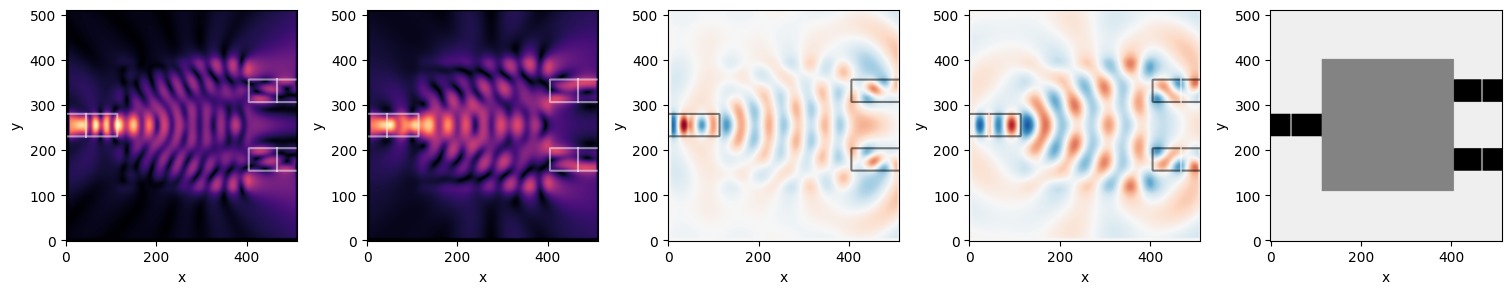

In [ ]:
rho, bg_rho, design_region, input_slice, output_slice1, output_slice2 = init_domain(Nx, Ny, Npml, space=space, wg_width=model.ports[0].width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region,  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

# Setup source
source1 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_init, m=1)
source2 = insert_mode(omega2, dl, input_slice.x, input_slice.y, model.epsilon_r(design), m=1)


# Setup probe
probe1 = insert_mode(omega1, dl, output_slice1.x, output_slice1.y, epsr_init, m=1)
probe2 = insert_mode(omega2, dl, output_slice2.x, output_slice2.y, epsr_init, m=1)
# Simulate initial device
simulation1,simulation2,ax,fig = viz_sim(epsr_init, source1, slices=[input_slice, output_slice1, output_slice2])

# get normalization factor (field overlap before optimizing)
_, _, Ez1 = simulation1.solve(source1)
_, _, Ez2 = simulation2.solve(source2)

E011 = mode_overlap(Ez1/np.sqrt(2), probe1)
E012 = mode_overlap(Ez1/np.sqrt(2), probe2)

E022 = mode_overlap(Ez2/np.sqrt(2), probe2)
E021 = mode_overlap(Ez2/np.sqrt(2), probe1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/200 | Duration: 23.33 secs | Value: 1.000000e+00
Epoch:   2/200 | Duration: 21.52 secs | Value: 8.294640e-01
Epoch:   3/200 | Duration: 21.63 secs | Value: 1.162891e+00
Epoch:   4/200 | Duration: 23.67 secs | Value: 8.766249e-01
Epoch:   5/200 | Duration: 21.75 secs | Value: 3.052770e+00
Epoch:   6/200 | Duration: 21.78 secs | Value: 5.135972e+00
Epoch:   7/200 | Duration: 22.01 secs | Value: 6.672736e+00
Epoch:   8/200 | Duration: 21.68 secs | Value: 7.660128e+00
Epoch:   9/200 | Duration: 22.42 secs | Value: 8.082855e+00
Epoch:  10/200 | Duration: 21.52 secs | Value: 8.551784e+00
Epoch:  11/200 | Duration: 22.05 secs | Value: 9.300557e+00
Epoch:  12/200 | Duration: 21.80 secs | Value: 9.527119e+00
Epoch:  13/200 | Duration: 21.88 secs | Value: 9.674143e+00
Epoch:  14/200 | Duration: 21.95 secs | Value: 9.948561e+00
Epoch:  15/200 | Duration: 21.63 secs | Value: 9.870292e+00
Epoch:  16/200 | Duration: 21.63 secs | Value: 1.011225e+01
Epoch:  17/200 | Duration: 21.71 secs | 

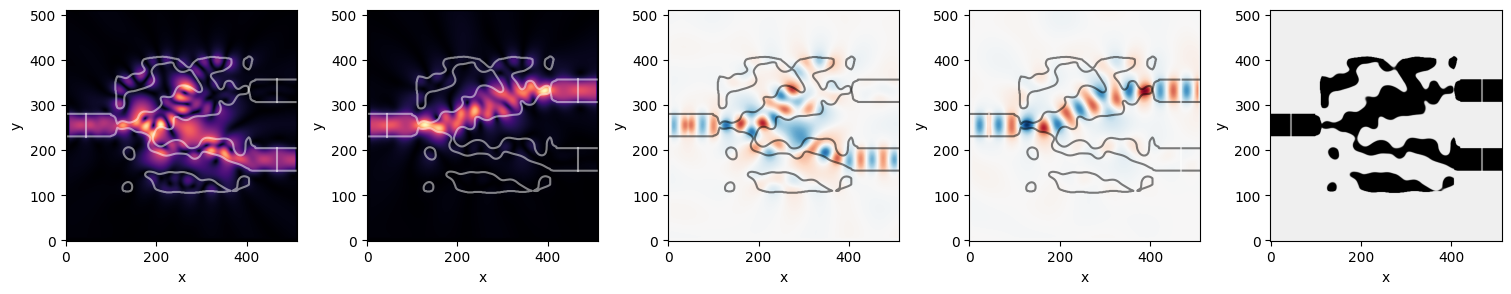

In [ ]:
def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation1.eps_r = epsr
    simulation2.eps_r = epsr
    _, _, Ez1 = simulation1.solve(source1)
    _, _, Ez2 = simulation2.solve(source2)

    return (mode_overlap(Ez1/np.sqrt(2), probe1) / E011) * (mode_overlap(Ez2/np.sqrt(2),probe2) / E022) 

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=200, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

viz_sim(epsr, source1, slices=[input_slice, output_slice1, output_slice2]);
